In [1]:
# conda install -c anaconda cython

## 1. 誤差拡散法の実装

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2

import numba
from halftone_c import halftone  # cython

In [2]:
# Visual Model 用パラメータ
A0 = 0.21
A1 = 0.32
A2 = 0.31
A3 = 0.13
B  = 0.04
C  = 1.00

AQ0 = A0
AQ1 = A1
AQ2 = A2
AQ3 = A3
BQ  = B
CQ0 = -AQ0 / B
CQ1 = -AQ1 / B
CQ2 = -AQ2 / B
CQ3 = -AQ3 / B

# 一様量子化器 (Nbit)
def uniform_quantizer_1bit(img):
    img[img >= 128] = 255
    img[img < 128]  = 0
    return img

# 一様量子化器 (Nbit)
def uniform_quantizer_Nbit(img, N):
    level = pow(2, N)
    d = 255 / (level-1)
    return np.round(img / d) * d

# logarithmic quantizer
def logarithmic_quantizer_Nbit(img, N):
    level = pow(2, N)
    scale_factor = 1 / np.log2(np.max(img)+1)
    quantized_image = np.clip(np.round(np.clip(scale_factor*np.log2(img+1), 0, level-1)), 0, 255)
    print(np.unique(quantized_image))
    
    return quantized_image.astype(np.uint8)

# Halftone with ODQ (1bit)
@numba.njit
def halftone_visual_model_1bit(img):
    threshold = 128

    xi = np.zeros((img.shape[1]+2, img.shape[0]+1))
    vd = np.zeros((img.shape[1], img.shape[0]), dtype=np.int64)
    ud = img.T

    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            tmp = np.array([[CQ0,CQ1,CQ2,CQ3,1]]) @ np.array([[xi[i,j],xi[i,j+1],xi[i+1,j], xi[i+2,j],ud[i,j]]]).T
            if tmp > threshold:
                vd[i,j] = 255
            A1 = np.array([[AQ0,AQ1,AQ2,AQ3,BQ]])
            A2 = np.array([[xi[i,j],xi[i,j+1],xi[i+1,j],xi[i+2,j],(vd[i,j] - ud[i,j])]]).T
            xi[i+1, j+1] = (A1 @ A2)[0,0]

    return vd.T

# Halftone with ODQ (Nbit)
@numba.njit
def halftone_visual_model_Nbit(img, N):
    level = pow(2, N)
    d = 255 / (level-1)

    xi = np.zeros((img.shape[1]+2, img.shape[0]+1))
    vd = np.zeros((img.shape[1], img.shape[0]), dtype=np.int64)
    ud = img.T

    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            vd[i,j] = np.round(((np.array([[CQ0,CQ1,CQ2,CQ3,1]]) @ np.array([[xi[i,j],xi[i,j+1],xi[i+1,j], xi[i+2,j],ud[i,j]]]).T)[0, 0] / d)) * d
            xi[i+1, j+1] = (np.array([[AQ0,AQ1,AQ2,AQ3,BQ]]) @ np.array([[xi[i,j],xi[i,j+1],xi[i+1,j],xi[i+2,j],(vd[i,j] - ud[i,j])]]).T)[0,0]

    return vd.T

# halftone with error diffusion
@numba.njit
def halftone_error_diffusion_1bit(img, method="jjn"):

    # Processing
    if method == "jjn":
        ## Jarvis, Judice & Ninke
        h = np.array([[0, 0, 0, 7, 5],
                      [3, 5, 7, 5, 3],
                      [1, 3, 5, 3, 1]]) / 48 ;
        FSTEPJ = 2
        BSTEPJ = -2
        FSTEPI = 2 
    if method == "fs":
        h = np.array([[0, 0, 7],
                      [3, 5, 1]]) /16
        FSTEPJ = 1
        BSTEPJ = -1
        FSTEPI = 1

    tmp1 = np.concatenate((np.ones((img.shape[0], -BSTEPJ)), img, np.ones((img.shape[0], FSTEPJ))), axis=1)
    tmp2 = np.concatenate((np.ones((FSTEPI, -BSTEPJ)), np.ones((FSTEPI, img.shape[1])), np.ones((FSTEPI, FSTEPJ))), axis=1)
    tmp = np.concatenate((tmp1, tmp2), axis=0)

    newImage = np.zeros((img.shape[0]+FSTEPI, img.shape[1]+FSTEPJ - BSTEPJ), dtype=np.int64)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]+FSTEPJ):
            if (i > img.shape[0] or j > img.shape[1] - BSTEPJ or j <= -BSTEPJ):
                    newImage[i,j] = 255 if tmp[i,j] > 128 else 0
            else:
                err1 = tmp[i,j] - 0
                err2 = tmp[i,j] - 255

                if (err1 * err1 < err2 * err2):
                    newImage[i,j] = 0
                    err3 = err1
                else:
                    newImage[i,j] = 255
                    err3 = err2

                for k in range(1, FSTEPI + 2):
                    for l in range(BSTEPJ, FSTEPJ+1):
                        tmp[i+k-1, j+l] += err3 * h[k-1, -1*BSTEPJ+l]

    return newImage[:-FSTEPI, :-(FSTEPJ-BSTEPJ)]

## 2. 実行時間の記録

In [6]:
img = cv2.imread("../datasets/samples/imgs/freiburg.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print("===== TEST halftone with numba =====")
%timeit _ = uniform_quantizer_1bit(img_gray)
%timeit _ = uniform_quantizer_Nbit(img_gray, 3)
%timeit _ = halftone_visual_model_1bit(img_gray)
%timeit _ = halftone_visual_model_Nbit(img_gray, 3)
%timeit _ = halftone_error_diffusion_1bit(img_gray, method="jjn")

print("===== TEST halftone with cython =====")
%timeit _ = halftone.uniform_quantizer_1bit_cy(img_gray)
%timeit _ = halftone.uniform_quantizer_Nbit_cy(img_gray, 3)
%timeit _ = halftone.halftone_visual_model_1bit_cy(img_gray)
%timeit _ = halftone.halftone_visual_model_Nbit_cy(img_gray, 3)
%timeit _ = halftone.halftone_error_diffusion_1bit_cy(img_gray, method="jjn")

===== TEST halftone with numba =====
315 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
491 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
195 ms ± 3.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
185 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.98 ms ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
===== TEST halftone with cython =====
317 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
788 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.17 s ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.62 s ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.2 s ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
img = cv2.imread("imgs/parrots.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Image Size: (256, 256)


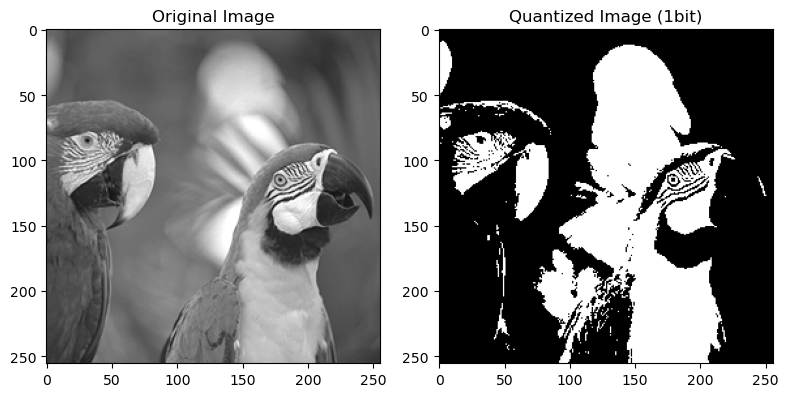

In [31]:
# 一様量子化器

img_quantize = uniform_quantizer_Nbit(img_gray, 1)

print(f"Image Size: {img_gray.shape}")

plt.figure(figsize=(8,8), dpi=100)
plt.subplot(121)
plt.imshow(img_gray, cmap="gray")
plt.title("Original Image")
plt.subplot(122)
plt.imshow(img_quantize, cmap="gray")
plt.title("Quantized Image (1bit)")

plt.tight_layout()
plt.show()

Image Size: (256, 256)


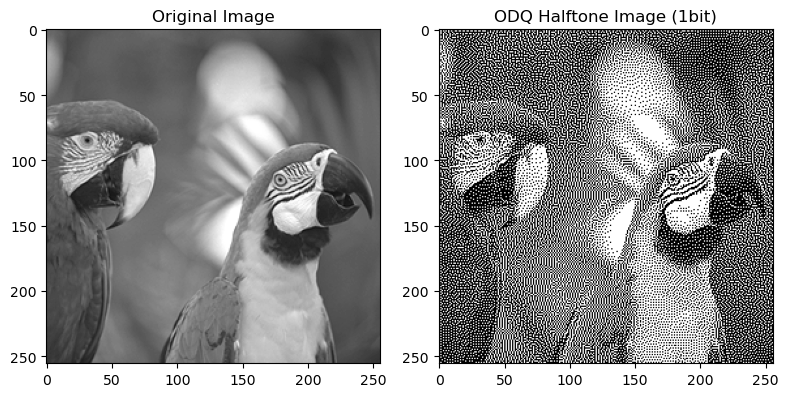

In [32]:
## initial setup (1: ODQ, 2: ErrorDiffusion, 3: DitherMatrix)

## Way.1 Visual Model(Fornasini-Marchesini)
img_halftone = halftone_visual_model_Nbit(img_gray, 1)

print(f"Image Size: {img_gray.shape}")


plt.figure(figsize=(8,8), dpi=100)
plt.subplot(121)
plt.imshow(img_gray, cmap="gray")
plt.title("Original Image")
plt.subplot(122)
plt.imshow(img_halftone, cmap="gray")
plt.title("ODQ Halftone Image (1bit)")

plt.tight_layout()
plt.show()

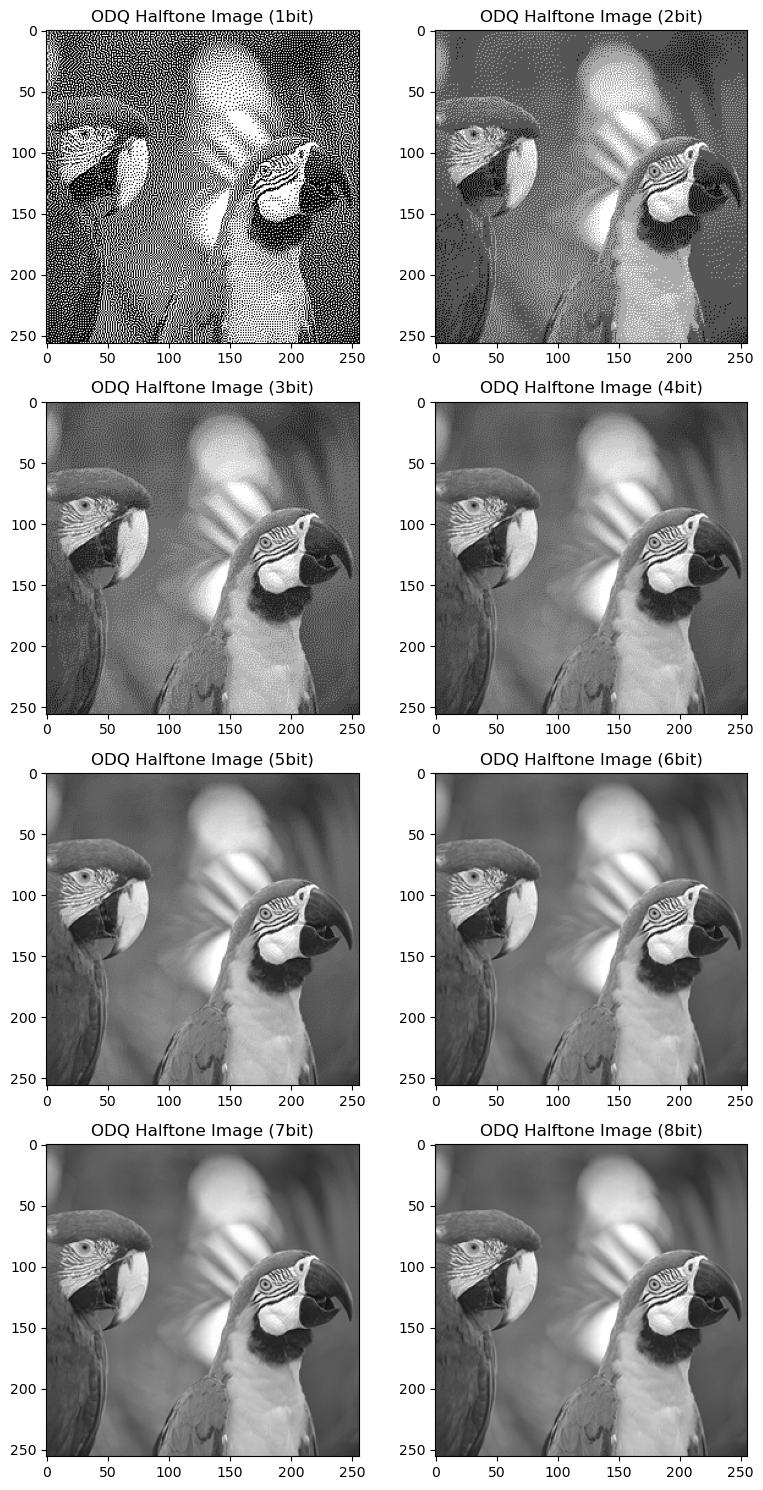

In [34]:
plt.figure(figsize=(8,15), dpi=100)

for i in range(1, 9):
    img_halftone = halftone_visual_model_Nbit(img_gray, i)
    
    plt.subplot(420 + i)
    plt.imshow(img_halftone, cmap="gray")
    plt.title(f"ODQ Halftone Image ({i}bit)")
        
plt.tight_layout()
plt.show()

Image_raw Size: (256, 256)
Image_fs  Size: (256, 256)
Image_jjn Size: (256, 256)


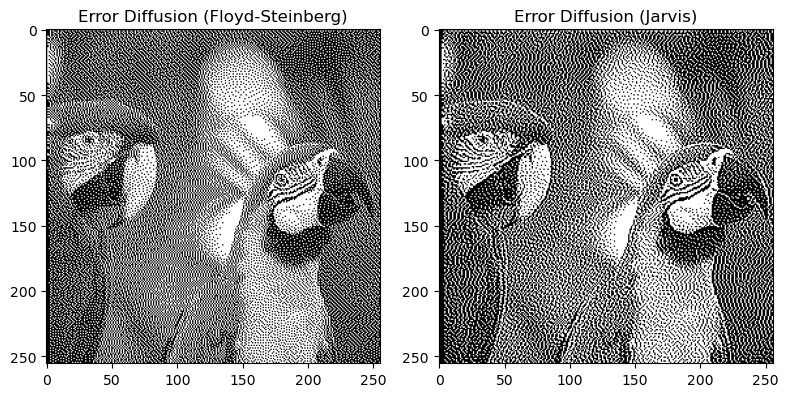

In [53]:
## Way.2 ErrorDiffusion (Floyd-Steinberg or Jarvis, Judice & Ninke)

img_halftone1 = halftone_error_diffusion_1bit(img_gray, "fs")
img_halftone2 = halftone_error_diffusion_1bit(img_gray, "jjn")

print(f"Image_raw Size: {img_gray.shape}")
print(f"Image_fs  Size: {img_halftone1.shape}")
print(f"Image_jjn Size: {img_halftone2.shape}")

plt.figure(figsize=(8,8), dpi=100)
plt.subplot(121)
plt.imshow(img_halftone1, cmap="gray")
plt.title("Error Diffusion (Floyd-Steinberg)")
plt.subplot(122)
plt.imshow(img_halftone2, cmap="gray")
plt.title("Error Diffusion (Jarvis)")

plt.tight_layout()
plt.show()

## 3. 生成したハーフトーン画像の保存

In [4]:
import pathlib
from tqdm import tqdm
from glob import glob

from halftone_video import HalftoneVideo

In [7]:
# generate simple_quantization image

RAW_DIR = "/Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz/rgbd_freiburg1_xyz_visual_model/rgbd_dataset_freiburg1_xyz_1bit/depth"
GOAL_DIR = [f"/Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/{i}bit" for i in range(1, 8)]

# RAW_DIR = "/Users/tsy/slamFolder/datasets/rgbd_freiburg1_floor/rgbd_freiburg1_floor_uniform_quantization/rgbd_dataset_freiburg1_floor_8bit/rgb"
# GOAL_DIR = [f"/Users/tsy/slamFolder/datasets/rgbd_freiburg1_floor/rgbd_freiburg1_floor_uniform_quantization/rgbd_dataset_freiburg1_floor_u_{i}bit/rgb" for i in range(1, 8)]


for i, goal_dir in enumerate(GOAL_DIR):
    h_video = HalftoneVideo(RAW_IMAGE_DIR=RAW_DIR, HALFTONE_IMAGE_DIR=goal_dir)
    h_video.create_halftone_video(option="visual_model", bit=i+1)

100%|█████████████████████████████████████████| 798/798 [02:43<00:00,  4.89it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/1bit


100%|█████████████████████████████████████████| 798/798 [02:32<00:00,  5.23it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/2bit


100%|█████████████████████████████████████████| 798/798 [02:33<00:00,  5.21it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/3bit


100%|█████████████████████████████████████████| 798/798 [02:34<00:00,  5.17it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/4bit


100%|█████████████████████████████████████████| 798/798 [02:32<00:00,  5.24it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/5bit


100%|█████████████████████████████████████████| 798/798 [02:31<00:00,  5.26it/s]


=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/6bit


100%|█████████████████████████████████████████| 798/798 [02:32<00:00,  5.23it/s]

=== HALFTONE COMPLETE b ^_^ d ===
[SAVED DIRECTORY] /Users/tsy/slamFolder/datasets/rgbd_freiburg1_xyz//rgbd_freiburg1_xyz_visual_model/depth/7bit


## 4. その他のテスト

In [ ]:
# [Version.1]
# def halftone_visual_model_py(img, N):
#     # parameters
#     A0 = np.array([[0.21]])
#     A1 = np.array([[0.32]])
#     A2 = np.array([[0.31]])
#     A3 = np.array([[0.13]])
#     B  = np.array([[0.04]])
#     C  = np.array([[1]])
    
#     level = pow(2, N)
#     d = 255 / (level-1)

#     # processing
#     AQ0 = A0
#     AQ1 = A1
#     AQ2 = A2
#     AQ3 = A3
#     BQ  = B
#     CQ0 = -np.linalg.inv(C@B) @ C @ AQ0
#     CQ1 = -np.linalg.inv(C@B) @ C @ AQ1
#     CQ2 = -np.linalg.inv(C@B) @ C @ AQ2
#     CQ3 = -np.linalg.inv(C@B) @ C @ AQ3

#     xi = np.zeros((img.shape[1]+2, img.shape[0]+1))
#     vd = np.zeros((img.shape[1], img.shape[0]))
#     ud = img.T

#     for j in range(img.shape[0]):
#         for i in range(img.shape[1]):
#             vd[i,j] = np.round((CQ0 * xi[i,j] + CQ1 * xi[i,j+1] + CQ2 * xi[i+1,j] + CQ3 * xi[i+2,j] + ud[i,j]) / d) * d
#             xi[i+1, j+1] = AQ0 * xi[i,j] + AQ1 * xi[i,j+1] + AQ2 * xi[i+1,j] + AQ3 * xi[i+2,j] + BQ * (vd[i,j] - ud[i,j])

#     vd = vd.T
    
#     return vd

In [20]:
# img = cv2.imread("imgs/test.jpg")
# imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgHalftone = halftone.halftone_visual_model_cy(imgGray, 1)

# cv2.imwrite("imgs/img_copy.jpg", img)
# cv2.imwrite("imgs/img_gray.jpg", imgGray)
cv2.imwrite("imgs/img_halftone_v.jpg", imgHalftone)

True

In [3]:
%%time

N = 100000
x = 213

for _ in range(N):
    np.round(x/255)*255

CPU times: user 203 ms, sys: 2.39 ms, total: 205 ms
Wall time: 204 ms


In [31]:
%%time

N = 100000
x = 213

for _ in range(N):
    if x < 127:
        x = 255
    else:
        x = 0

CPU times: user 16.2 ms, sys: 608 µs, total: 16.8 ms
Wall time: 16.4 ms


In [59]:
img = cv2.imread("../datasets/samples/imgs/freiburg.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = np.clip(img, 0., 255.)